# Feature Extraction Test for Functions 07 - 12

In [176]:
import numpy as np
import sklearn
from skimage import measure
from skimage import morphology
import cv2
import os
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.transform import rotate
from sklearn.cluster import KMeans
from math import pi

imgDir = os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir, "data"))

### Function for testing numerical Features

In [177]:
def testNumerical(imageNames, imgDirectory, numericalFeature, mask=False):
    imgs = []
    features = []

    #set flag for reading images
    imReadFlags = 1
    if mask:
        imReadFlags = cv2.IMREAD_GRAYSCALE#set to grayscale for masks
    #read images
    for imName in imageNames:
        imgs.append(cv2.imread(os.path.join(imgDirectory, imName), imReadFlags))
    #convert to  binary mask if we're dealing with masks
    if mask:
        for img in imgs:
            _, img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
    #convert to rgb for further processing (if no mask)
    if(not mask):
        imgs = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in imgs]
    #extract features
    for img in imgs:
        features.append(numericalFeature(img))

    #also convert masks to rgb for displaying
    if(mask):
        imgs = [cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) for img in imgs]

    #display images and corresponding features
    rows = np.floor(np.sqrt(len(imageNames))).astype(int)
    cols = np.ceil(np.sqrt(len(imageNames))).astype(int)
    fig, axes = plt.subplots(rows, cols, figsize=(10, 8))
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i < len(imgs):
            ax.imshow(imgs[i])
            ax.set_title(f"Feature: {features[i]}")
            ax.axis("off")
    plt.tight_layout()
    plt.show()


### 07: Computing number of bright, non-saturated pixels in image

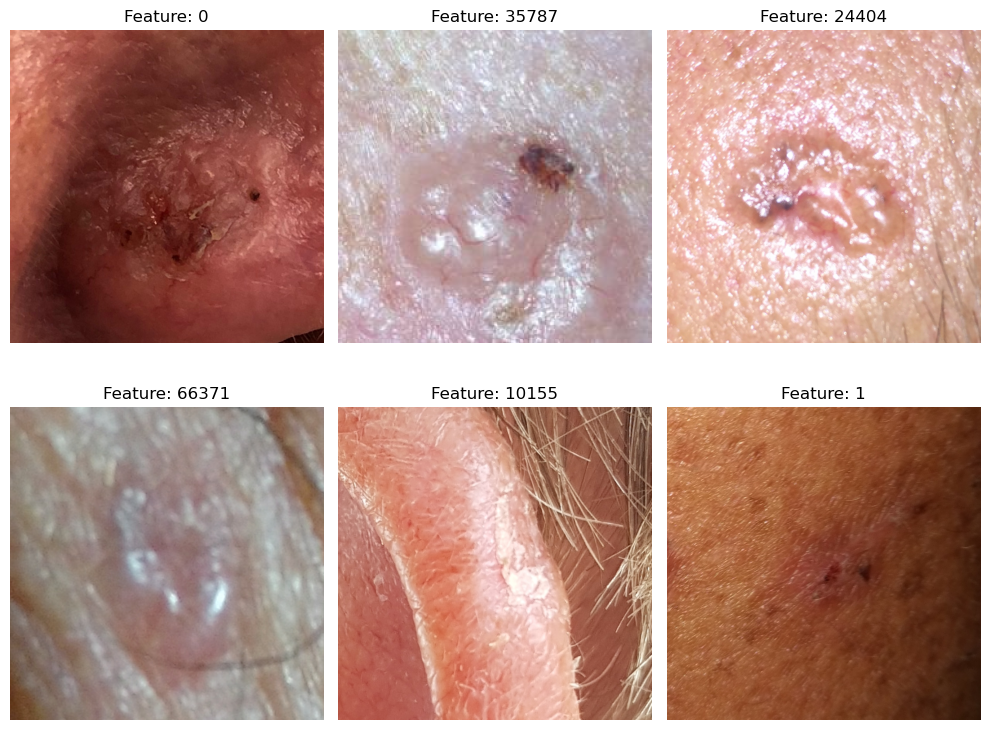

In [178]:
def measure_regression(image):
    """Computes number of bright, non-saturated pictures in the image.
    
    :param image: The BGR image to be analysed
    :return: The number of pixels in the image with
    low saturation (0-30) and high brightness(150-255)
    measured in the hsv color fomat"""
   
    hsv_img = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    #set lower and upper limit for hsv values of colors to be selected.
    lower_color = np.array([0, 0, 150])
    upper_color = np.array([180, 30, 255])
    #mask pixels in range
    mask = cv2.inRange(hsv_img, lower_color, upper_color)
    #get number of pixels in range
    num_pixels = cv2.countNonZero(mask)

    return num_pixels

#get test images from dataset
imNames = ["PAT_13_21_350.png", "PAT_62_97_868.png", "PAT_63_98_127.png", "PAT_90_139_57.png", "PAT_148_220_174.png", "PAT_180_756_831.png"]

testNumerical(imNames, imgDir, measure_regression)

### 08: Compactness (returns garbabe)

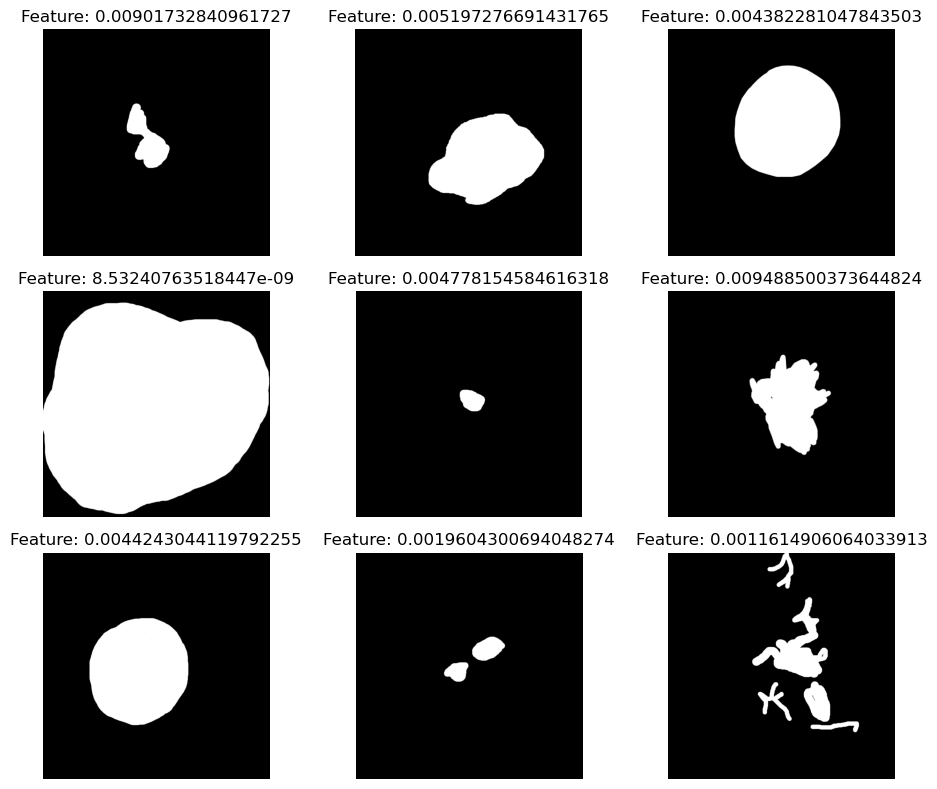

In [179]:
def get_compactness(mask):
    """Computes the compactness measure for the given binary mask.
    
    :param mask: The Binary mask to be analyzed
    :return: Compactness measure \"Circularity\"
    from 0 to inf, where lower values indicate
    higher compactness."""
    # mask = color.rgb2gray(mask)
    area = np.sum(mask)
    struct_el = morphology.disk(3)
    #erode mask once
    mask_eroded = morphology.binary_erosion(mask, struct_el)
    #subtract eroded mask from original mask to obtain border pixels -> get number of border pixels with sum
    #perimeter = np.sum(mask - mask_eroded)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    perimeter = cv2.arcLength(contours[0], True)
    #calculate and return "compactness" measure
    return perimeter**2 / (4 * np.pi * area)

imgs = ["PAT_9_17_80_mask.png", "PAT_13_21_350_mask.png", "PAT_16_24_691_mask.png", "PAT_31_43_129_mask.png", "PAT_34_47_108_mask.png", "PAT_38_1002_34_mask.png", "PAT_39_55_233_mask.png", "PAT_53_81_522_mask.png", "PAT_54_83_405_mask.png"]

testNumerical(imgs, imgDir, get_compactness, mask=True)

### 09: Asymmetry (+ 12 & 13)

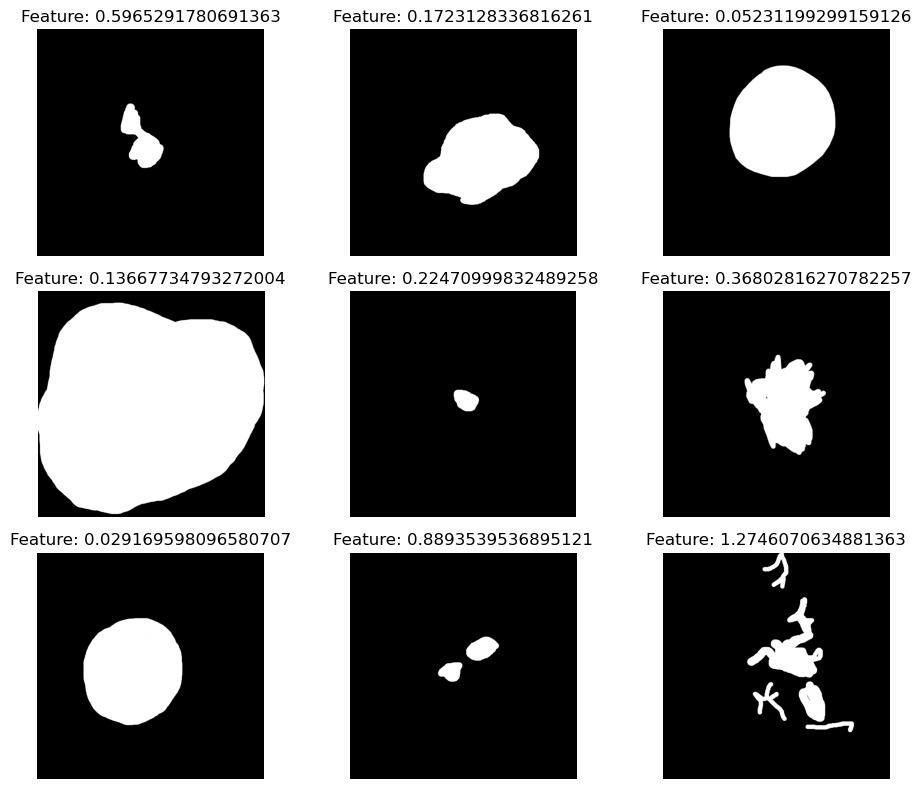

In [180]:
def find_midpoint_v4(mask):
        """Finds horizontal midpoint of the given binary
        mask, such that 50% of nonzero pixels in the mask
        are on either side of midpoint.

        :param mask: Binary Mask to be examined.
        :return x: horizontal coordinate of midpoint."""
        #get horizontal vector which contains number of nonzero pixels for each mask column
        summed = np.sum(mask, axis=0)
        #calculate 50% of nonzero pixels in mask as threshold
        half_sum = np.sum(summed) / 2
        #iterate through columns until half of nonzero pixels in mask have been reached
        for i, n in enumerate(np.add.accumulate(summed)):
            if n > half_sum:
                #return x-coordinate at shich 50% of nonzero pixels where exceeded
                return i

def crop(mask):
        """Crops a given binary mask tighly on the vertical axis
        and centrally on the horizontal axis. The x-axis center is
        measured such that on both sides there are 50%
        of nonzero mask pixels. The border for the x-crop
        is then the midpoing +- the larger distance from
        the midpoint to the left and right border.

        :param mask: Binary Mask to be cropped.
        :return: cropped mask"""
        #compute x-midpoint
        mid = find_midpoint_v4(mask)
        #get y & x coordinates of nonzero points
        y_nonzero, x_nonzero = np.nonzero(mask)
        #set ylims to be lowest and highest points where mask contains nonzero pixel
        y_lims = [np.min(y_nonzero), np.max(y_nonzero)]
        #compute initial x limit
        x_lims = np.array([np.min(x_nonzero), np.max(x_nonzero)])
        #compute x-limit from x-center +- larger distance from midpoint to left/right border
        x_dist = max(np.abs(x_lims - mid))
        x_lims = [mid - x_dist, mid+x_dist]
        #crop mask with computed limits & return
        return mask[y_lims[0]:y_lims[1], x_lims[0]:x_lims[1]]

def get_asymmetry(mask):
    """Computes the asymmetry for a given binary mask
    by rotating 6 times 30°.
    
    
    :param mask: The Binary mask to be analyzed
    :return: Asymmetry measure from 0 to 1 where
    0 is perfect asymmetry and 1 is perfect symmetry."""
    # mask = color.rgb2gray(mask)
    scores = []
    for _ in range(6):
        #crop mask to only look at the nonzero area
        segment = crop(mask)
        #(np.sum(segment))
        #append ratio of non-overlapping pixels between flipped mask and original mask over total mask pixels
        scores.append(np.sum(np.logical_xor(segment, np.flip(segment))) / (np.sum(segment)))
        #rotate mask for next iteration
        mask = rotate(mask, 30)
        #return average score
    return sum(scores) / len(scores)


imgs = ["PAT_9_17_80_mask.png", "PAT_13_21_350_mask.png", "PAT_16_24_691_mask.png", "PAT_31_43_129_mask.png", "PAT_34_47_108_mask.png", "PAT_38_1002_34_mask.png", "PAT_39_55_233_mask.png", "PAT_53_81_522_mask.png", "PAT_54_83_405_mask.png"]

testNumerical(imgs, imgDir, get_asymmetry, mask=True)

### 10 & 11 get_multicolor_rate (kinda works)

In [181]:
# def get_multicolor_rate(im, mask, n):
#     """Computes the maximum euclidean distance between
#     2 dominant colors in the masked area of the image
#     that are adjacent in the hierarchy of dominance.
#     Uses kmeans with n clusters to find centroids that
#     represent \"dominant\" colors and compares only
#     colors such that > 8% of the masked area are
#     clustered with this color.
    
#     :param image: The BFR or RGB image to analyze
#     :param mask: The binary mask to apply to the image
#     :param n: Number of clusters to use forMeans Color Clustering
#     :return: Maxiumum euclidean distance between 2 dominant colors
#     in the masked area of the image, which are adjacent in the
#     hierarchy of dominance. Note that return is the same for BGR
#     and RGB images."""
#     # mask = color.rgb2gray(mask)
#     #scale image down for performance
#     im = resize(im, (im.shape[0] // 4, im.shape[1] // 4), anti_aliasing=True)
#     mask = resize(
#         mask, (mask.shape[0] // 4, mask.shape[1] // 4), anti_aliasing=True
#     )
#     im2 = im.copy()
#     im2[mask == 0] = 0

#     columns = im.shape[0]
#     rows = im.shape[1]
#     col_list = []
#     #create list of all colors present in masked area of image
#     for i in range(columns):
#         for j in range(rows):
#             if mask[i][j] != 0:
#                 col_list.append(im2[i][j] * 256)
#     #return empty string if nothing masked
#     if len(col_list) == 0:
#         return ""
#     #find n clusters of dominant colors
#     cluster = KMeans(n_clusters=n, n_init=10).fit(col_list)
#     #obtain sorted list of dominant colors that cover > 8% of masked area
#     com_col_list = get_com_col(cluster, cluster.cluster_centers_)

#     dist_list = []
#     m = len(com_col_list)
#     #return empty string if there is only 1 or 0 dominant colors
#     if m <= 1:
#         return ""
#     #compute euclidean distances between adjacent colors
#     for i in range(0, m - 1):
#         j = i + 1
#         col_1 = com_col_list[i]
#         col_2 = com_col_list[j]
#         dist_list.append(
#             np.sqrt(
#                 (col_1[0] - col_2[0]) ** 2
#                 + (col_1[1] - col_2[1]) ** 2
#                 + (col_1[2] - col_2[2]) ** 2
#             )
#         )
#     #return max distance between 2 adjacent colors
#     return np.max(dist_list)

# def get_com_col(cluster, centroids):
#     """Computes a sorted list of dominant colors given
#     the KMeans clusters and centroids for all clusters
#     that contain > 8% of pixels. The list is sorted by
#     the proportion of pixels covered by this cluster.
    
#     :param cluster: KMeans object fitted on pixel values of an image.
#     :param centroids: centroids of the KMeans algorithm, i.e. central
#     pixels of the clusters specified in \"cluster\".
#     :return: Sorted list of dominant colors, sorted by proportion,
#     excluding all clusters that cover <8% of the pixels."""
#     com_col_list = []
#     #create labels for the number of clusters (dominant colors)
#     labels = np.arange(0, len(np.unique(cluster.labels_)) + 1)
#     #count frequencies of each label with histogram
#     (hist, _) = np.histogram(cluster.labels_, bins=labels)
#     hist = hist.astype("float")
#     #normalize histogram to calculate proportions
#     hist /= hist.sum()

#     #Commented out the parts that are redundant for computationand  and only produce a visualization
#     #rect = np.zeros((50, 300, 3), dtype=np.uint8)
#     colors = sorted([(percent, color) for (percent, color) in zip(hist, centroids)], key= lambda x:x[0])
#     #start = 0
#     for percent, color in colors:
#         if percent > 0.08:
#             com_col_list.append(color)
#         # end = start + (percent * 300)
#         # cv2.rectangle(
#         #     rect,
#         #     (int(start), 0),
#         #     (int(end), 50),
#         #     color.astype("uint8").tolist(),
#         #     -1,
#         # )
#         # start = end
#     return com_col_list


# imgNames = ["PAT_120_183_623.png", "PAT_145_216_158.png", "PAT_211_319_810.png", "PAT_270_1382_561.png", "PAT_324_1465_43.png", "PAT_359_4450_86.png"]
# maskNames = ["PAT_120_183_623_mask.png", "PAT_145_216_158_mask.png", "PAT_211_319_777_mask.png", "PAT_270_1382_561_mask.png", "PAT_324_1465_43_mask.png", "PAT_359_4450_86_mask.png"]

# #imgNames = ["PAT_120_183_623.png"]
# #maskNames = ["PAT_120_183_623_mask.png"]

# imgs = []
# features = []
# masks = []

# #read images
# for i in range(len(imgNames)):
#     imgs.append(cv2.imread(os.path.join(imgDir, imgNames[i])))
#     masks.append(cv2.imread(os.path.join(imgDir, maskNames[i]), cv2.IMREAD_GRAYSCALE))#read mask
#     _, masks[-1] = cv2.threshold(masks[-1], 127, 255, cv2.THRESH_BINARY)#binarize the mask
# #mask images
# for i in range(len(imgNames)):
#     (imgs[i])[(masks[i])==0] = 0
# #extract features
# for i in range(len(imgNames)):
#     print(i)
#     features.append(get_multicolor_rate(imgs[i], masks[i], 4))
# #convert to rgb for plotting
# imgs = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in imgs]

# #display images and corresponding features
# rows = np.floor(np.sqrt(len(imgNames))).astype(int)
# cols = np.ceil(np.sqrt(len(imgNames))).astype(int)
# fig, axes = plt.subplots(rows, cols, figsize=(10, 8))
# axes = axes.flatten()

# for i, ax in enumerate(axes):
#     if i < len(imgs):
#         ax.imshow(imgs[i])
#         ax.set_title(f"Feature: {features[i]}")
#         ax.axis("off")
# plt.tight_layout()
# plt.show()

# B-Feature: Irregular Border

In [182]:
# def find_midpoint_v1(image):
    
#     row_mid = image.shape[0] / 2     # nr of the middle row
#     col_mid = image.shape[1] / 2     # nr of the middle column
#     return row_mid, col_mid


# def irregularBorder(img, mask) -> int:
#     """Extract the \"irregular Boder\" feature,
#     which is a number from 0 to 1 that is a measure
#     for the difference between the center intensity
#     and border intensity of the lesion.
    
#     :param img: the image to process
#     :param mask: mask to apply to the image
#     :return: border irregularity measure from
#     0(regular) to 1(irregular)"""
    


# imgDir = os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir, "data"))
# imName = "PAT_72_110_647.png"
# maskName = "PAT_72_110_647_mask.png"
# testImg = cv2.imread(os.path.join(imgDir, imName))
# testMask = cv2.imread(os.path.join(imgDir, maskName), cv2.IMREAD_GRAYSCALE)
# _, testMask = cv2.threshold(testMask, 127, 255, cv2.THRESH_BINARY)

# print(f"Irregular Border: {irregularBorder(testImg, testMask)}")

# B-feature from example.py

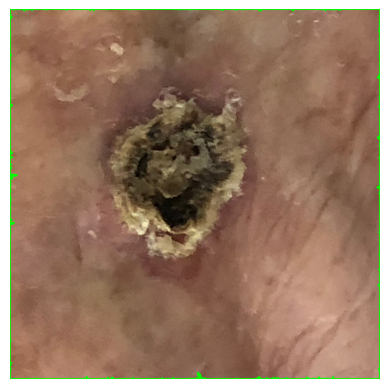

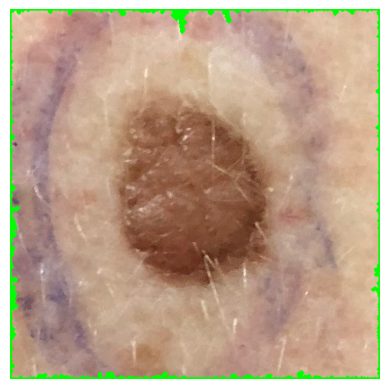

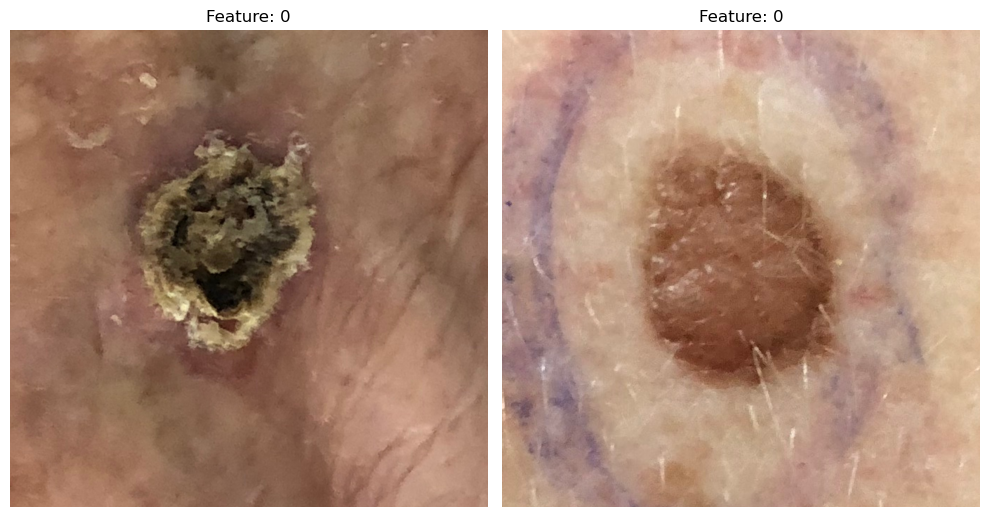

In [183]:
def measure_streaks(image) -> int:
    """Computes the irregularity of the lesion in the given (RGB) image.
    
    :param image: The BGR image to be analysed
    :return: The irregularity score of the lesion

    """
   # get grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # compute threshold, using 11 neighbors
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

    # find the contours of the thresholded image
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # compute area and perimeter of the contours
    lesion_area = cv2.contourArea(contours[0])
    border_perimeter = cv2.arcLength(contours[0], True)

    imgContoured = image.copy()
    cv2.drawContours(imgContoured, contours, -1, (0, 255, 0), 3)
    plt.imshow(imgContoured)
    plt.axis("off")
    plt.show()

    # finally evaluate irregularity
    if lesion_area == 0:
        irregularity = 0
    else:
        irregularity = (border_perimeter ** 2) / (4 * np.pi * lesion_area)

    return irregularity


# imgs = ["PAT_120_183_623.png", "PAT_145_216_158.png", "PAT_211_319_810.png", "PAT_270_1382_561.png", "PAT_324_1465_43.png", "PAT_359_4450_86.png"]
#imgs = ["PAT_20_29_850.png"]
imgs = ["PAT_27_38_240.png", "PAT_29_40_561.png"]
#imgs = ["PAT_29_40_561.png"]
#imgs = ["PAT_38_1003_68.png"]
testNumerical(imgs, imgDir, measure_streaks)